# Task 4: Forecasting Financial Inclusion in Ethiopia

## Objective
Forecast `ACC_OWNERSHIP` and `USG_DIGITAL_PAYMENT` for 2025-2027 using:
1.  **Baseline Trends**: Historical data (2011-2024).
2.  **Event Augmentation**: Quantified impacts of key policy/market events.
3.  **Scenario Analysis**: Low, Base, and High reform intensity scenarios.

## Inputs
- `data/raw/ethiopia_fi_unified_data.csv`: Unified dataset.
- `data/processed/event_indicator_matrix.csv`: Event-Indicator impact associations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading and Preparation

In [2]:
# Load data
unified_df = pd.read_csv('../data/raw/ethiopia_fi_unified_data.csv')

def get_magnitude_numeric(magnitude_str):
    mapping = {
        'high': 0.2,
        'medium': 0.1,
        'low': 0.05,
        'negligible': 0.01
    }
    return mapping.get(str(magnitude_str).lower(), 0.0)

# Filter for historical observations
obs_df = unified_df[unified_df['record_type'] == 'observation'].copy()
obs_df['observation_date'] = pd.to_datetime(obs_df['observation_date'])

## 2. Baseline Modeling
We use linear regression on available historical data. If history is sparse (e.g., `USG_DIGITAL_PAYMENT`), we use `ACC_OWNERSHIP` slope as a proxy for the baseline trend.

In [3]:
def train_baseline_model(history_df):
    if len(history_df) < 2:
        return None, None
    X = history_df['observation_date'].map(datetime.toordinal).values.reshape(-1, 1)
    y = history_df['value_numeric'].values
    
    slope, intercept = np.polyfit(X.flatten(), y, 1)
    return slope, intercept

def calculate_event_add_ons(unified_df, start_date, end_date, target_indicator):
    timeline = pd.date_range(start=start_date, end=end_date, freq='ME')
    total_impact = np.zeros(len(timeline))
    
    impact_links = unified_df[unified_df['record_type'] == 'impact_link']
    
    for idx, row in impact_links.iterrows():
        target = row.get('indicator_code')
        if pd.isna(target): target = row.get('indicator')
        
        # Handle alias
        if target == 'USG_DIGITAL_PAY': target = 'USG_DIGITAL_PAYMENT'
        if target_indicator == 'USG_DIGITAL_PAY': target_indicator = 'USG_DIGITAL_PAYMENT'
        
        if target != target_indicator: continue
            
        mag = row.get('impact_estimate')
        if pd.isna(mag):
            mag = get_magnitude_numeric(row.get('impact_magnitude'))
        else:
            mag = float(mag)
            
        direction = 1 if row.get('impact_direction', 'increase') == 'increase' else -1
        final_impact = mag * direction
        
        parent = row['parent_id']
        event_row = unified_df[(unified_df['record_type'] == 'event') & 
                               ((unified_df['record_id'] == parent) | (unified_df['indicator_code'] == parent))]
        
        if event_row.empty: continue
        
        evt_date = pd.to_datetime(event_row.iloc[0]['observation_date'])
        if pd.isna(evt_date): continue

        lag = float(row.get('lag_months', 0))
        impact_start = evt_date + timedelta(days=int(lag*30))
        ramp_days = 180
        
        for i, t in enumerate(timeline):
            if t < impact_start:
                continue
            days_since = (t - impact_start).days
            factor = min(1.0, days_since / ramp_days)
            total_impact[i] += final_impact * factor
            
    return pd.Series(total_impact, index=timeline)

## 3. Scenario Generation

In [4]:
def generate_forecast(slope, intercept, impact_series, scenario='Base'):
    forecast_dates = impact_series.index
    X_future = forecast_dates.map(datetime.toordinal).values
    
    baseline = slope * X_future + intercept
    impacts = impact_series.values
    
    if scenario == 'Optimistic':
        adjusted_baseline = baseline * 1.05
        adjusted_impacts = impacts * 1.2
    elif scenario == 'Pessimistic':
        adjusted_baseline = baseline * 0.95 
        adjusted_impacts = impacts * 0.8
    else:
        adjusted_baseline = baseline
        adjusted_impacts = impacts
        
    final_forecast = np.clip(adjusted_baseline + adjusted_impacts, 0, 100)
    return pd.DataFrame({'Date': forecast_dates, 'Value': final_forecast, 'Scenario': scenario})

# Execution Loop
indicators = ['ACC_OWNERSHIP', 'USG_DIGITAL_PAYMENT']
scenarios = ['Base', 'Optimistic', 'Pessimistic']
all_results = []

for ind in indicators:
    print(f"Processing {ind}...")
    lookup_ind = ind
    if ind == 'USG_DIGITAL_PAYMENT' and 'USG_DIGITAL_PAYMENT' not in obs_df['indicator_code'].unique():
        lookup_ind = 'USG_DIGITAL_PAY'
    
    history = obs_df[obs_df['indicator_code'] == lookup_ind].sort_values('observation_date').drop_duplicates(subset=['observation_date'], keep='last')
    
    if len(history) < 2:
        if ind in ['USG_DIGITAL_PAYMENT', 'USG_DIGITAL_PAY']:
            print("Using proxy baseline from ACC_OWNERSHIP")
            acc_hist = obs_df[obs_df['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')
            slope, _ = train_baseline_model(acc_hist)
            # Anchor to single history point if available
            if len(history) == 1:
                latest_pt = history.iloc[-1]
                intercept = latest_pt['value_numeric'] - slope * datetime.toordinal(latest_pt['observation_date'])
            else:
                continue
        else:
            continue
    else:
        slope, intercept = train_baseline_model(history)
        
    impacts = calculate_event_add_ons(unified_df, '2020-01-01', '2027-12-31', ind)
    for s in scenarios:
        res = generate_forecast(slope, intercept, impacts, s)
        res['Indicator'] = ind
        all_results.append(res)

final_df = pd.concat(all_results)
final_df.head()

Processing ACC_OWNERSHIP...
Processing USG_DIGITAL_PAYMENT...
Using proxy baseline from ACC_OWNERSHIP


,Date,Value,Scenario,Indicator
0,2020-01-31,36.449632,Base,ACC_OWNERSHIP
1,2020-02-29,36.657186,Base,ACC_OWNERSHIP
2,2020-03-31,36.879053,Base,ACC_OWNERSHIP
3,2020-04-30,37.093764,Base,ACC_OWNERSHIP
4,2020-05-31,37.315632,Base,ACC_OWNERSHIP


## 4. Visualizations

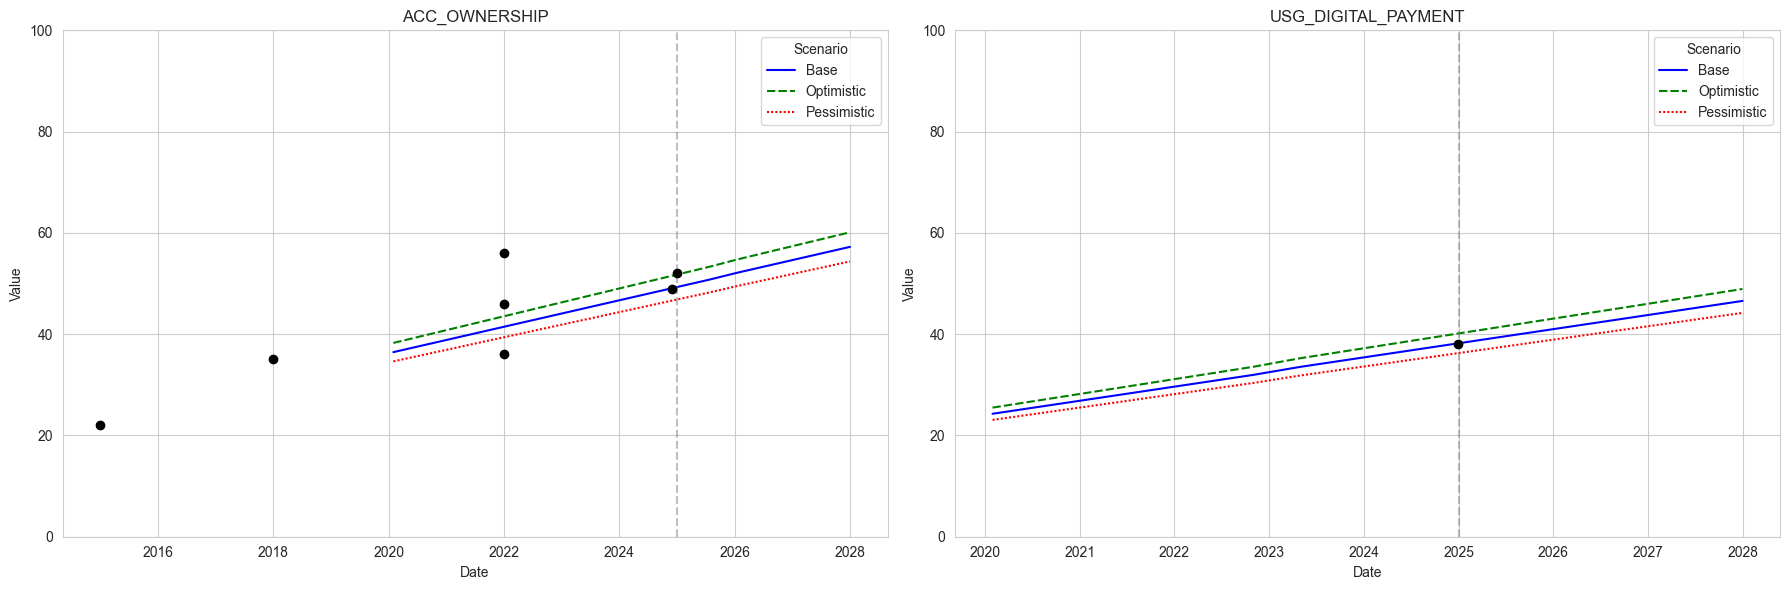

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, ind in enumerate(indicators):
    ax = axes[i]
    subset = final_df[final_df['Indicator'] == ind]
    
    # Forecasts
    sns.lineplot(data=subset, x='Date', y='Value', hue='Scenario', style='Scenario', ax=ax, palette={'Base': 'blue', 'Optimistic': 'green', 'Pessimistic': 'red'})
    
    # History
    lookup_ind = ind
    if ind == 'USG_DIGITAL_PAYMENT' and 'USG_DIGITAL_PAYMENT' not in obs_df['indicator_code'].unique():
        lookup_ind = 'USG_DIGITAL_PAY'
    hist_data = obs_df[obs_df['indicator_code'] == lookup_ind]
    ax.scatter(hist_data['observation_date'], hist_data['value_numeric'], color='black', zorder=5, label='Historical')
    
    ax.set_title(ind)
    ax.set_ylim(0, 100)
    ax.axvline(pd.Timestamp('2025-01-01'), color='gray', linestyle='--', alpha=0.5)
    
plt.tight_layout()
plt.show()